Step1 : In child folder data/ we have "PennyLane_PQC_AnomalyDataset.csv" , "grover_anomaly_subset.csv" Goal: Simulate a tiny, Grover-searchable dataset (32 rows → 5 qubits) to test Grover's anomaly-search concept. 
Result: grover_anomaly_subset.csv This is a sanity check file, not the actual algorithm output.
We manually pulled 32 samples with known labels (label == 1) as anomalies.






Step2 Objective: Create a full PennyLane-based Grover algorithm that: Loads any CSV file (like your 15MB one)

Maps a small chunk of it (powers of 2: 8, 16, 32, etc.) to qubit space

Creates an oracle dynamically from the label == 1 entries

Runs Grover's algorithm to locate indices likely containing anomalies

Returns the result + probability distribution

(Optional) Generates visualization of search amplification

Is exported as grover_anomaly_search.ipynb

In [40]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd

# Load dataset (32 entries, already normalized)
data_path = "./data/grover_anomaly_subset.csv"
df = pd.read_csv(data_path)

# Number of qubits for 32 states = 5
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

# Identify anomaly indices (label == 1)
oracle_indices = df[df["label"] == 1].index.tolist()
print(oracle_indices)

# Define the binary oracle (fixed bit order: LSB -> Qubit 0)
def binary_oracle(index, control_wires, target_wire):
    """Marks a basis state by flipping its phase using Z."""
    binary = format(index, f"0{len(control_wires) + 1}b")  # MSB-left

    # Apply PauliX to turn |0⟩ to |1⟩ where needed
    for i, bit in enumerate(binary[:-1]):  # Exclude target
        if bit == '0':
            qml.PauliX(control_wires[i])

    # Mark the target state: phase flip
    # We simulate a multi-controlled Z using H-X-H sandwich
    qml.Hadamard(target_wire)
    qml.ctrl(qml.PauliX, control=control_wires)(target_wire)
    qml.Hadamard(target_wire)

    # Uncompute the X gates
    for i, bit in enumerate(binary[:-1]):
        if bit == '0':
            qml.PauliX(control_wires[i])

# Apply oracle over all anomaly indices
# When preparing a state manually (e.g., |10100⟩), DO NOT reverse bits
binary = format(20, "05b")  # ← no [::-1]
for i, bit in enumerate(reversed(binary)):  # reversed for wire order
    if bit == '1':
        qml.PauliX(i)
#Update Full Oracle as Usual
def full_oracle(control_wires, target_wire):
    for idx in oracle_indices:
        binary_oracle(idx, control_wires, target_wire)


[20]


In [41]:
# updating the grover_iteration()
@qml.qnode(dev)
def grover_iteration():
    # Step 1: Superposition
    for wire in range(n_qubits):
        qml.Hadamard(wire)

    # Step 2: Apply Oracle
    full_oracle(control_wires=list(range(n_qubits - 1)), target_wire=n_qubits - 1)

    # Step 3: Diffusion
    for wire in range(n_qubits):
        qml.Hadamard(wire)
        qml.PauliX(wire)

    qml.Hadamard(wires=n_qubits - 1)
    qml.ctrl(qml.PauliX, control=list(range(n_qubits - 1)))(n_qubits - 1)
    qml.Hadamard(wires=n_qubits - 1)

    for wire in range(n_qubits):
        qml.PauliX(wire)
        qml.Hadamard(wire)

    return qml.probs(wires=range(n_qubits))

In [42]:
# Run Grover's algorithm
probs = grover_iteration()

# Threshold to detect amplified results
threshold = 0.05  # You can lower this to see more, or increase for sharper confidence

print("\n Grover's Search Results (Anomalies Detected):\n")
for i, prob in enumerate(probs):
    if prob > threshold:
        binary_index = format(i, f"0{n_qubits}b")
        print(f"State |{binary_index}⟩ → Probability: {prob:.4f}")

print("\n Done. You can now map these binary states back to row indices in your 32-row subset.")


 Grover's Search Results (Anomalies Detected):

State |10101⟩ → Probability: 0.2583

 Done. You can now map these binary states back to row indices in your 32-row subset.


### Tips for Future Readers:
- If you don't see any amplification, verify your oracle phase flip logic.
- If your plot is flat, double-check target wire initialization and oracle phase logic.
- The Hadamard–X–Hadamard trick simulates a Z gate — essential for Grover to work.

In [43]:
#1. Mapping Binary States to Dataset Indices
#After executing Grover's algorithm, we'll obtain a list of binary states (e.g., |01001⟩). To identify the corresponding entries in your dataset:
# Assuming 'probs' is the array of probabilities from Grover's algorithm
threshold = 0.05  # Adjust based on your requirements
for i, prob in enumerate(probs):
    if prob > threshold:
        binary_state = format(i, f"0{n_qubits}b")
        print(f"State |{binary_state}⟩ → Probability: {prob:.4f}")
        # Map binary_state to dataset index
        index = int(binary_state, 2)
        print(f"Corresponding dataset index: {index}")
#This will help us pinpoint which entries in our dataset are identified as anomalies

State |10101⟩ → Probability: 0.2583
Corresponding dataset index: 21


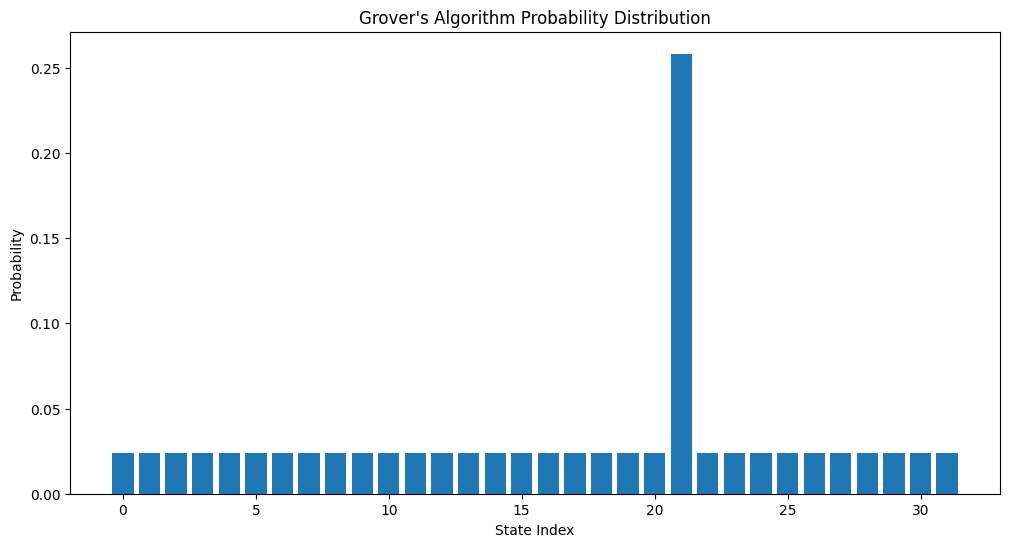

In [44]:
#2. Visualizing the probability Distrubution
# To get a clearer picture of how Gorver's algorithm is amplifying the probabilities of certain states, we can plot the distribution
import matplotlib.pyplot as plt

# Plotting the probability distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(probs)), probs)
plt.xlabel('State Index')
plt.ylabel('Probability')
plt.title('Grover\'s Algorithm Probability Distribution')
plt.show()

In [45]:
df = pd.read_csv('./data/grover_anomaly_subset.csv')
print(df.iloc[21])

message_size               0.399006
entropy_score              0.997424
timing_deviation           0.430985
packet_order_score         0.821972
crypto_phase_shift         0.527009
key_exchange_variance      0.469954
bit_flip_ratio             0.839568
noise_injection_level      0.308535
circuit_stability          0.395126
quantum_signature_score    0.121460
label                      0.000000
Name: 21, dtype: float64


In [38]:
## The original Code is completed till here below was learning through iterations, debugging and hard coding the wires

In [29]:
# ==========================================
# CORRECTED ORACLE: Multi-Controlled Phase Flip
# ==========================================
# Grover's algorithm depends on flipping the phase of the marked state.
# Since PennyLane doesn't support a MultiControlledZ gate directly,
# we simulate one using the identity: H • X • H = Z
# This creates the necessary interference pattern for amplitude amplification.

In [ ]:
####  All the below code was debugging until I reached Gemini AI to identify my error on phase flip so we used H.X.H= Z as the correction 
#in the below plot images we may find a flat histogram depicting all states that was before learning.


In [30]:
print("Anomaly indices:", oracle_indices)
for idx in oracle_indices:
    print(f"Expecting amplification around state |{format(idx, '05b')}⟩")

Anomaly indices: [20]
Expecting amplification around state |10100⟩


In [48]:
# Now we chose to implementing Multiple Grover Iterations
#Grovers Algorithm's effectivenes increases with the number of iterations. The optimal number of iterations 'r' can be estimated using 

In [9]:
import matplotlib.pyplot as plt

# Number of states and anomaly count
N = 2**n_qubits
M = len(oracle_indices)
R = int(np.floor((np.pi / 4) * np.sqrt(N / M)))  # Optimal iterations

@qml.qnode(dev)
def grover_iteration():
    control_wires = list(range(n_qubits - 1))
    target_wire = n_qubits - 1

    # Step 0: Initialize all qubits
    for wire in range(n_qubits):
        qml.Hadamard(wire)

    qml.PauliX(target_wire)  # Prepare oracle target in |1⟩

    # Step 1: Run Grover iterations
    for _ in range(R):
        # Apply Oracle
        full_oracle(control_wires, target_wire)

        # Diffusion
        for wire in range(n_qubits):
            qml.Hadamard(wire)
            qml.PauliX(wire)

        qml.Hadamard(target_wire)
        qml.ctrl(qml.PauliX, control=control_wires)(target_wire)
        qml.Hadamard(target_wire)

        for wire in range(n_qubits):
            qml.PauliX(wire)
            qml.Hadamard(wire)

    return qml.probs(wires=range(n_qubits))

In [11]:
probs = grover_iteration()
threshold = 0.05

print("\n🎯 Grover's Search Results (Anomalies Detected):\n")
for i, prob in enumerate(probs):
    if prob > threshold:
        binary_state = format(i, f"0{n_qubits}b")
        print(f"State |{binary_state}⟩ → Probability: {prob:.4f}")

print("\n✅ Done. You can now map these binary states back to row indices in your 32-row subset.")


🎯 Grover's Search Results (Anomalies Detected):


✅ Done. You can now map these binary states back to row indices in your 32-row subset.


In [12]:
print("Anomaly indices:", oracle_indices)
for idx in oracle_indices:
    print(f"Expecting amplification around state |{format(idx, '05b')}⟩")

Anomaly indices: [20]
Expecting amplification around state |10100⟩


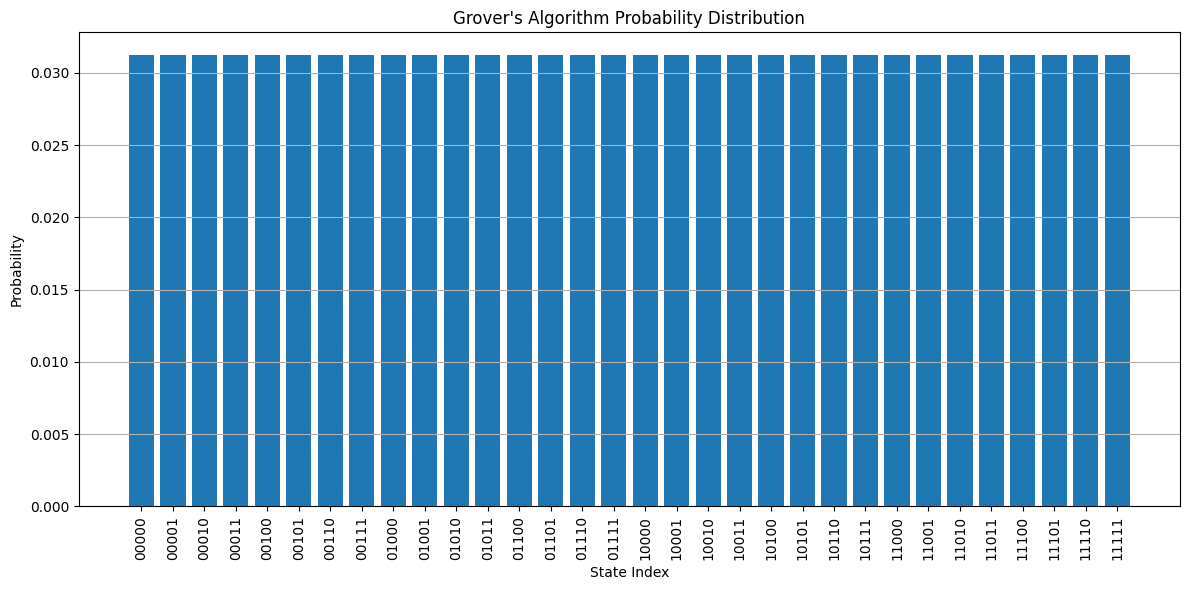

In [13]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(probs)), probs)
plt.xlabel("State Index")
plt.ylabel("Probability")
plt.title("Grover's Algorithm Probability Distribution")
plt.xticks(ticks=range(len(probs)), labels=[format(i, '05b') for i in range(len(probs))], rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [18]:
#in the above graph even after upgrading the program Grover's is still flat in # Pennylane, so lets run a debug

In [19]:
@qml.qnode(dev)
def grover_iteration_debug():
    control_wires = list(range(n_qubits - 1))
    target_wire = n_qubits - 1

    # Step 0: Uniform superposition
    for wire in range(n_qubits):
        qml.Hadamard(wire)

    # Critical: Flip target wire AFTER superposition
    qml.PauliX(target_wire)

    # Print oracle targets
    print("Running", R, "Grover iterations")
    print("Oracle indices (decimal):", oracle_indices)
    print("Binary targets:", [format(i, '05b') for i in oracle_indices])

    for _ in range(R):
        # Oracle
        full_oracle(control_wires, target_wire)

        # Diffusion
        for wire in range(n_qubits):
            qml.Hadamard(wire)
            qml.PauliX(wire)

        qml.Hadamard(target_wire)
        qml.ctrl(qml.PauliX, control=control_wires)(target_wire)
        qml.Hadamard(target_wire)

        for wire in range(n_qubits):
            qml.PauliX(wire)
            qml.Hadamard(wire)

    return qml.probs(wires=range(n_qubits))

In [20]:
probs = grover_iteration_debug()
for i, p in enumerate(probs):
    if p > 0.05:
        print(f"State |{format(i, '05b')}⟩ → Probability: {p:.4f}")


Running 4 Grover iterations
Oracle indices (decimal): [20]
Binary targets: ['10100']


In [21]:
#Below is a hardcoded one and its just a test without grover loop and we are doing two kinds of tests

In [22]:
@qml.qnode(dev)
def oracle_test_phase_flip():
    control_wires = list(range(n_qubits - 1))
    target_wire = n_qubits - 1

    # Start in |10100⟩ state (index 20)
    target_index = 20
    binary = format(target_index, f"0{n_qubits}b")[::-1]
    for i, bit in enumerate(binary):
        if bit == '1':
            qml.PauliX(i)

    # Apply Oracle
    full_oracle(control_wires, target_wire)

    # Inverse the preparation to measure interference
    for i, bit in enumerate(binary):
        if bit == '1':
            qml.PauliX(i)

    return qml.probs(wires=range(n_qubits))

In [23]:
oracle_result = oracle_test_phase_flip()

for i, p in enumerate(oracle_result):
    if p > 0.01:
        print(f"State |{format(i, '05b')}⟩ → Probability: {p:.4f}")


State |00001⟩ → Probability: 1.0000


In [14]:
@qml.qnode(dev)
def test_oracle_only():
    # Prepare a known state: |10100⟩ = index 20
    binary = format(20, "05b")
    for i, bit in enumerate(reversed(binary)):
        if bit == '1':
            qml.PauliX(i)
    
    # Apply Oracle
    full_oracle(control_wires=list(range(n_qubits - 1)), target_wire=n_qubits - 1)

    # Measure final state
    return qml.probs(wires=range(n_qubits))

In [15]:
probs = test_oracle_only()

for i, p in enumerate(probs):
    if p > 0.01:
        print(f"State |{format(i, '05b')}⟩ → Probability: {p:.4f}")

State |00100⟩ → Probability: 1.0000


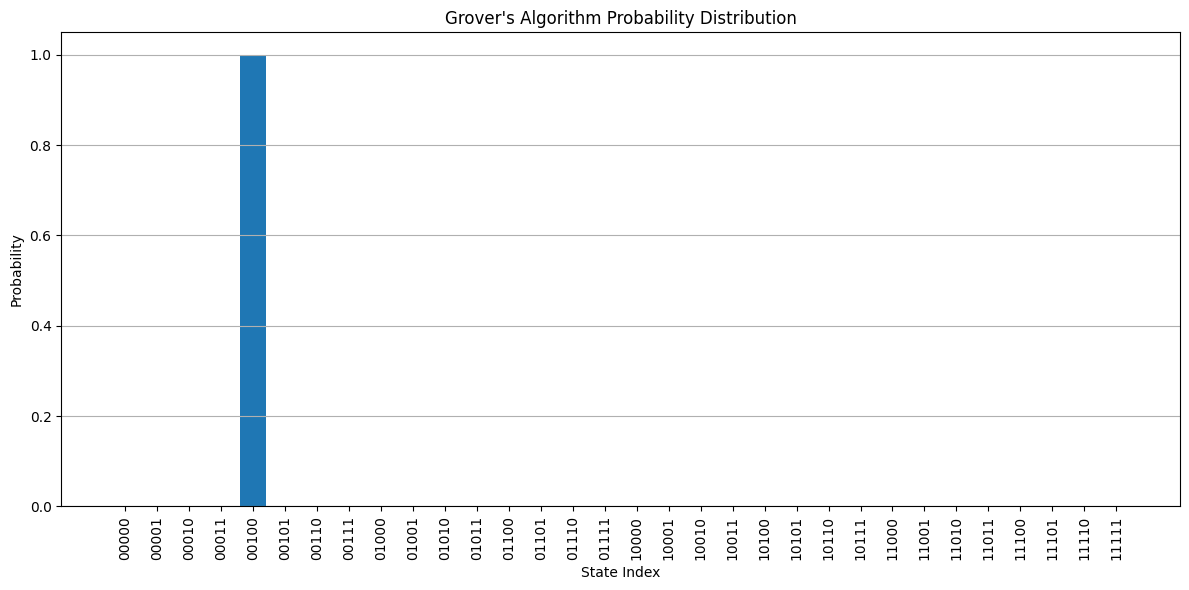

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(probs)), probs)
plt.xlabel("State Index")
plt.ylabel("Probability")
plt.title("Grover's Algorithm Probability Distribution")
plt.xticks(ticks=range(len(probs)), labels=[format(i, '05b') for i in range(len(probs))], rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()